In [1]:
!pip install -q tflite-model-maker

In [2]:
import os
from pathlib import Path

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

2022-02-13 17:46:14.614484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 17:46:14.614499: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/manuel/.virtualenvs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version.

# Load Data

In [3]:
#image_path = Path("data/v1_explicit/")
image_path = Path("data/v2_simple/")

In [4]:
data_check = [(f.name, len(list(f.glob("*.jpg")))) for f in Path(image_path).iterdir() if f.is_dir()]
data_check.sort(key=lambda x:x[1], reverse=True)
data_check

[('other', 8005), ('zenith', 3229), ('nadir', 2998)]

In [5]:
data = DataLoader.from_folder(image_path)

train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

INFO:tensorflow:Load image with size: 14232, num_label: 3, labels: nadir, other, zenith.


2022-02-13 17:46:16.512030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 17:46:16.512446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 17:46:16.512490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-13 17:46:16.512519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-13 17:46:16.512545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

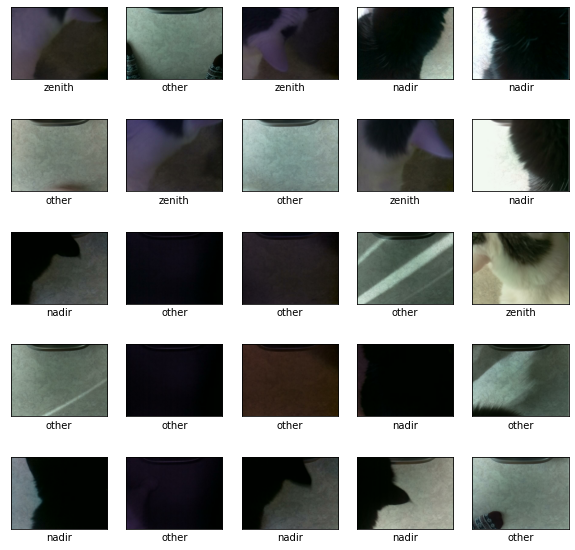

In [6]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

# Train Model

In [7]:
model = image_classifier.create(
    train_data, 
    validation_data=validation_data,
    shuffle=True,
    epochs=10,
    batch_size=128,
    model_spec="efficientnet_lite0",
    # model_spec=model_spec.get("mobilenet_v2"),
)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/10


/home/manuel/.virtualenvs/tf/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


88/88 [==============================] - 117s 1s/step - loss: 0.4591 - accuracy: 0.9256 - val_loss: 0.3831 - val_accuracy: 0.9613
Epoch 2/10
88/88 [==============================] - 115s 1s/step - loss: 0.3896 - accuracy: 0.9588 - val_loss: 0.3661 - val_accuracy: 0.9691
Epoch 3/10
88/88 [==============================] - 115s 1s/step - loss: 0.3779 - accuracy: 0.9649 - val_loss: 0.3587 - val_accuracy: 0.9719
Epoch 4/10
88/88 [==============================] - 114s 1s/step - loss: 0.3717 - accuracy: 0.9684 - val_loss: 0.3540 - val_accuracy: 0.9747
Epoch 5/10
88/88 [==============================] - 114s 1s/step - loss: 0.3672 - accuracy: 0.9701 - val_loss: 0.3513 - val_accuracy: 0.9768
Epoch 6/10
88/88 [==============================] - 117s 1s/step - loss: 0.3635 - accuracy: 0.9714 - val_loss: 0.3486 - val_accuracy: 0.9768
Epoch 7/10
88/88 [==============================] - 115s 1s/step - loss: 0.3599 - accuracy: 0.9741 - val_loss: 0.3461 - val_accuracy: 0.9796
Epoch 8/10
88/88 [======

# Evaluate Model

In [8]:
loss, accuracy = model.evaluate(test_data)

45/45 [==============================] - 11s 221ms/step - loss: 0.3500 - accuracy: 0.9754


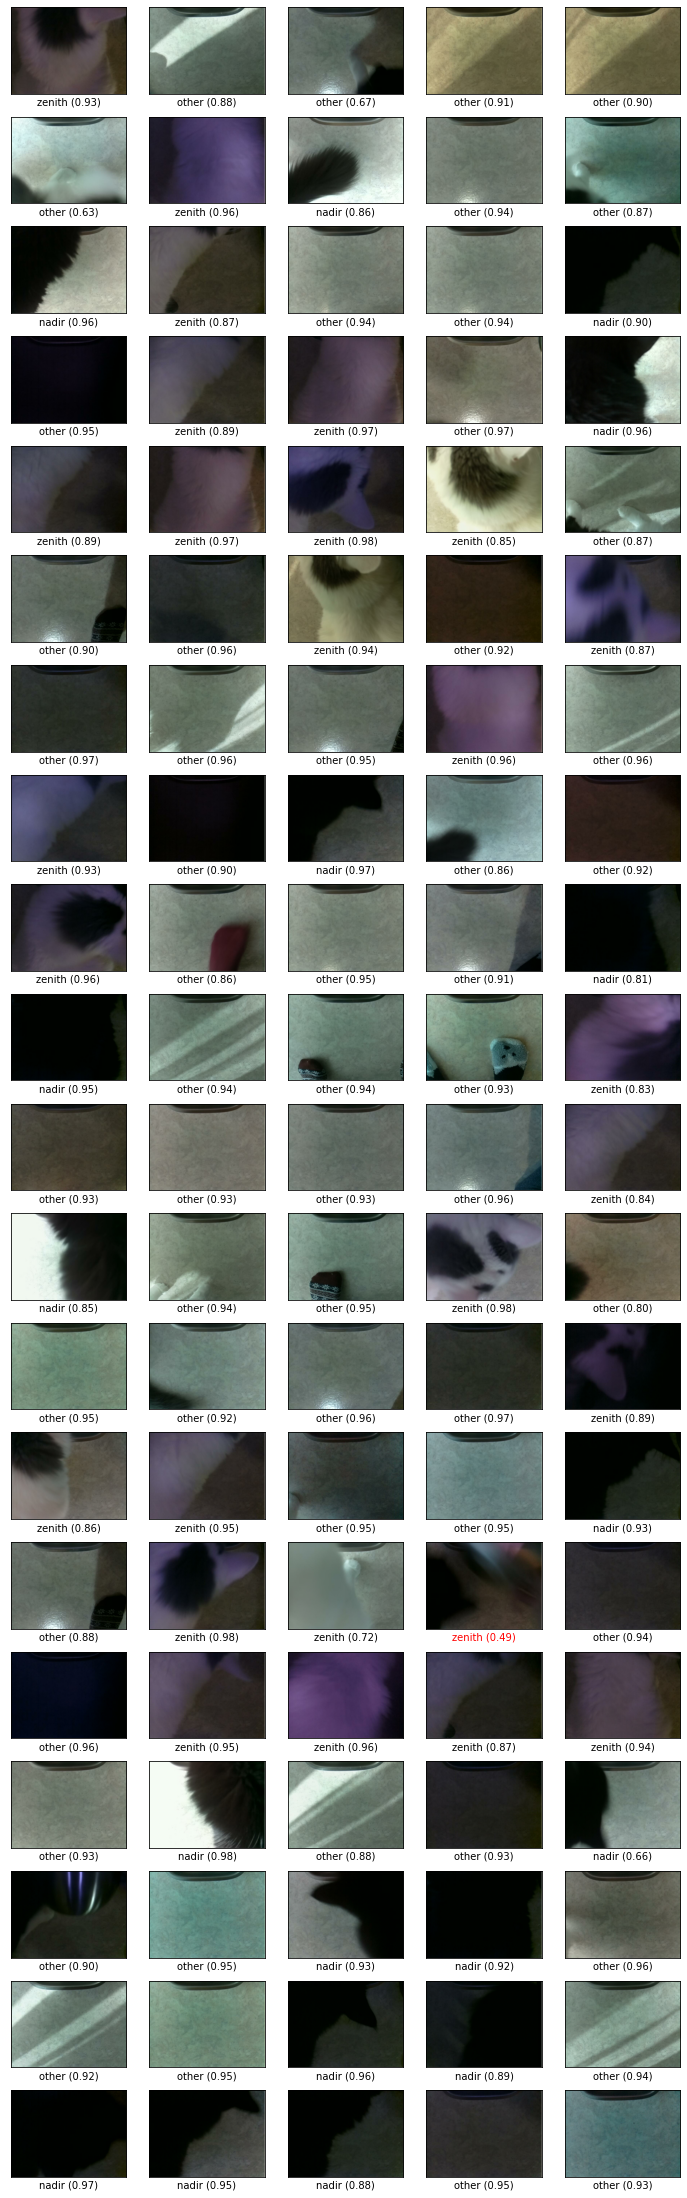

In [38]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
    if val1 == val2:
        return 'black'
    else:
        return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(12, 40))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
    ax = plt.subplot(20, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    
    predict_label = predicts[i][0][0]
    certainty = predicts[i][0][1]
    color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
    ax.xaxis.label.set_color(color)
    #plt.xlabel('Predicted: %s' % predict_label)
    plt.xlabel(f'{predict_label} ({certainty:.2f})')
plt.show()

# Export Model

In [34]:
model.export(export_dir='/home/manuel/Projects/CatFeeder/prototypes/6_classifier', 
             tflite_filename="mobilenet_model_v3.tflite",
             label_filename="labels_v3.txt")

INFO:tensorflow:Assets written to: /tmp/tmp44ajh94x/assets


INFO:tensorflow:Assets written to: /tmp/tmp44ajh94x/assets
2022-02-13 18:33:05.871376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 18:33:05.871731: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-02-13 18:33:05.871780: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-02-13 18:33:05.871996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-13 18:33:05.872252: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at http

INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp8xnn9qn1/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmp8xnn9qn1/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: /home/manuel/Projects/CatFeeder/prototypes/6_classifier/mobilenet_model_v3.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: /home/manuel/Projects/CatFeeder/prototypes/6_classifier/mobilenet_model_v3.tflite


In [33]:
def recreate_labels():
    # 1) We use this in order to ignore any hidden files that might be here.
    # 'Datasets' is the name of the folder where we store our training data. The 'listdir' is used to fetch all the folder names.
    labels = [folder for folder in os.listdir(image_path) if not folder.startswith('.')]
  
    # 2) Then, we output the contents of each folder name to a file.
    with open('labels_v3.txt', 'w') as file:
        for label in labels:
            file.write(label)
            file.write('\n')

recreate_labels()   

In [133]:
config = QuantizationConfig.for_float16()
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmp/tmpjl33qrtg/assets


INFO:tensorflow:Assets written to: /tmp/tmpjl33qrtg/assets
2022-02-05 18:45:44.721340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 18:45:44.721642: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-02-05 18:45:44.721690: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-02-05 18:45:44.721900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 18:45:44.722160: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at http

INFO:tensorflow:Label file is inside the TFLite model with metadata.


2022-02-05 18:45:45.135601: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-02-05 18:45:45.135630: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpehv61yyr/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpehv61yyr/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_fp16.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_fp16.tflite
